# Figure 1: Athletes Brain Study - Refactored

This notebook demonstrates the refactored, modular approach to generating Figure 1 for the athletes brain study.
The analysis has been organized into reusable modules within the `athletes_brain.fig1` package.

## Setup and Imports

Import the refactored modules from our package.

In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-09-25 16:07:08.375 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


## Configuration

Set up the configuration and visualization settings.

In [2]:
# Initialize configuration
config = Fig1Config()
config.METRICS = ["gm_vol"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


## Quick Analysis: Generate Complete Figure 1

Use the main function to generate all comparisons and visualizations.

In [3]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "behavioral"
output_dir.mkdir(parents=True, exist_ok=True)
# generate_figure1(output_dir=output_dir, config=config)

## Step-by-Step Analysis

For more control, we can run each step individually using the modular components.

### 1. Data Loading

In [4]:
# # Initialize data loader
# data_loader = AthletesBrainDataLoader(config)

# # Load all data
# metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

# print(f"Loaded {len(metric_data)} metrics")
# print(f"Loaded {len(parcels)} brain parcels")
# print(f"Metrics: {list(metric_data.keys())}")

# # Display sample data (demographics)
# df = metric_data["gm_vol"]
# df["subject_code"] = (
#     df["subject_code"]
#     .astype(str)
#     .str.replace("-", "")
#     .str.replace(" ", "")
#     .str.replace("_", "")
#     .str.zfill(4)
# )
# df = df.drop_duplicates(subset=["subject_code"], keep="first")

# print(f"N participants: {df.shape[0]}")

In [5]:
df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov["subject_code"] = (
    df_cov["subject_code"]
    .astype(str)
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("_", "")
)
df_cov = df_cov.drop_duplicates(subset=["subject_code"])

In [6]:
# df_cov[df_cov["subject_code"] == "FNCL41"]["weekly_workouts"]
df_cov["filled"].value_counts()

filled
True     2565
False     663
Name: count, dtype: int64

In [7]:
df_cov.loc[df_cov["filled"], "weekly_workouts"] = df_cov.loc[
    df_cov["filled"], "weekly_workouts"
].fillna(0)
df_cov["weekly_workouts"] = df_cov["weekly_workouts"].replace({"10 שעות ויותר": 10})
df_cov.loc[df_cov["weekly_workouts"].notna(), "weekly_workouts"] = df_cov.loc[
    df_cov["weekly_workouts"].notna(), "weekly_workouts"
].astype(int)
df_cov = df_cov.dropna(subset=["weekly_workouts"])

In [8]:
MAX_NUMBER_OF_WORKOUTS = 0

# write a query to detect atheletes (study == "sport", condition != "learning")
ATHLETES_QUERY = "(condition in ['Professional', 'Control']) & (group in ['Climbing', 'Bjj'])"
LEARNERS_QUERY = "(condition in ['Learning']) & (group in ['Climbing', 'Bjj'])"

target_subjects = df_cov.query(ATHLETES_QUERY)["subject_code"].unique()
learner_subjects = df_cov.query(LEARNERS_QUERY)["subject_code"].unique()

# locate subjects that have more than MAX_NUMBER_OF_WORKOUTS
subjects_to_drop = df_cov[
    (~df_cov["subject_code"].isin(target_subjects))
    & (~df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] > MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()
valid_learners = df_cov[
    (df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] <= MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()

In [9]:
df_cov["target"] = df_cov["subject_code"].isin(target_subjects)
df_cov["learner"] = df_cov["subject_code"].isin(learner_subjects)
df_cov["cs_valid"] = True
df_cov.loc[
    (df_cov["learner"]) & (~df_cov["target"]) & (~df_cov["subject_code"].isin(valid_learners)),
    "cs_valid",
] = False
# drop "subjects_to_drop"
df_cov = df_cov[~df_cov["subject_code"].isin(subjects_to_drop)]

In [10]:
df_cov = df_cov.dropna(subset=["target"])

In [11]:
df_cov["target"] = df_cov["target"].astype(str)
df_cov["sex"] = df_cov["sex"].astype(str)
df_cov["age_c"] = df_cov["age_at_scan"] - df_cov["age_at_scan"].mean()
df_cov["BMI"] = df_cov["weight"] / ((df_cov["height"] / 100) ** 2)

### 2. Statistical Analysis

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


def class_balance_weights(s, target_mix=None):
    # s: Series with values "True"/"False" for athlete/control (strings)
    p_obs = s.value_counts(normalize=True).to_dict()
    if target_mix is None:
        target_mix = {"True": 0.5, "False": 0.5}  # choose your target mix
    return s.map(lambda g: target_mix[g] / p_obs[g])


def analyze_with_class_weights(df, target_mix=None, robust=None, metric: str = "adc"):
    d = df.dropna(subset=["value", "target", "sex", "age_at_scan"]).copy()
    d["target"] = d["target"].astype(str)
    d["sex"] = d["sex"].astype(str)
    d["age_c"] = d["age_at_scan"] - d["age_at_scan"].mean()
    w = class_balance_weights(d["target"], target_mix=target_mix)

    formula = "value ~ C(target, Treatment(reference='False')) " "+ C(sex) + age_c + I(age_c**2)"
    if "vol" in metric:
        formula += " + tiv"

    fit = smf.wls(formula, data=d, weights=w).fit(cov_type=(robust or "nonrobust"))

    # effect (athletes vs controls) is the coefficient on the target indicator:
    coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
    t = fit.tvalues[coef_name]
    df_r = fit.df_resid
    r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
    r2_partial = t**2 / (t**2 + df_r)
    out = {
        "target_mix": target_mix or {"True": 0.5, "False": 0.5},
        "coef_delta": float(fit.params[coef_name]),
        "t": float(t),
        "r_partial": float(r_partial),
        "r2_partial": float(r2_partial),
        "ci95": tuple(map(float, fit.conf_int().loc[coef_name])),
        "p_value": float(fit.pvalues[coef_name]),
        "n": len(d),
        # effective n is useful to report with weights:
        "effective_n": float((w.sum() ** 2) / (w.pow(2).sum())),
    }
    return out, fit

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

behav_columns = [
    "BMI",
    "salary",
    "pcl5",
    "sos_q",
    # "weekly_workouts",
    "psychometric_score",
    "swls",
    "hli",
    "gad7",
    "psqi",
    "oasis",
    "phq9",
    "screen_time",
    "smartphone_usage",
    "home_cooking_times_per_week",
    "working_with_computer_times_per_week",
    "recreational_activity_times_per_week",
    "water",
    "alcohol",
    "sugar_beverages",
]


behav_vis = {
    "BMI": "BMI",
    "salary": "Salary",
    "pcl5": "PCL-5 (PTSD)",
    "sos_q": "SOS-Q",
    "psychometric_score": "Psychometric Score",
    "swls": "SWLS (Satisfaction)",
    "hli": "HLI (Health Life Index)",
    "gad7": "GAD-7 (Generalized Anxiety Disorder)",
    "psqi": "PSQI (Sleep)",
    "oasis": "OASIS (Anxiety)",
    "phq9": "PHQ-9 (Depression)",
    "screen_time": "Screen Time",
    "smartphone_usage": "Smartphone Usage",
    "home_cooking_times_per_week": "Home Cooking (times/week)",
    "working_with_computer_times_per_week": "Working with Computer (times/week)",
    "recreational_activity_times_per_week": "Recreational Activity (times/week)",
    "water": "Water (cups/day)",
    "alcohol": "Alcohol (drinks/week)",
    "sugar_beverages": "Sugar Beverages (drinks/week)",
}

domains = {
    "BMI": "Physical Health",
    "salary": "Socioeconomic Status",
    "pcl5": "Mental Health",
    "sos_q": "Mental Health",
    "psychometric_score": "Mental Health",
    "swls": "Mental Health",
    "hli": "Mental Health",
    "gad7": "Mental Health",
    "psqi": "Mental Health",
    "oasis": "Mental Health",
    "phq9": "Mental Health",
    "screen_time": "Lifestyle",
    "smartphone_usage": "Lifestyle",
    "home_cooking_times_per_week": "Lifestyle",
    "working_with_computer_times_per_week": "Lifestyle",
    "recreational_activity_times_per_week": "Lifestyle",
    "water": "Lifestyle",
    "alcohol": "Lifestyle",
    "sugar_beverages": "Lifestyle",
}

results_template = pd.DataFrame(
    columns=[
        "target_col",
        "vis_col",
        "domain",
        "coef_delta",
        "t",
        "r_partial",
        "r2_partial",
        "ci95_lo",
        "ci95_hi",
        "p_value",
        "n_controls",
        "n_athletes",
    ]
)
results = {}

for group in ["all", "climbing", "bjj"]:
    results[group] = results_template.copy()
    for i, target_col in enumerate(behav_columns):
        d = df_cov.dropna(subset=[target_col])
        d = d[d["cs_valid"]]
        if group != "all":
            d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() != group)].index)
        # d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() == "bjj")].index)

        w = class_balance_weights(d["target"].astype(str))

        fit = smf.wls(
            f"{target_col} ~ C(target, Treatment(reference='False')) + C(sex) + age_c + I(age_c ** 2)",
            data=d,
            weights=w,
        ).fit()
        fit.summary()

        # get "clean" coefficients for plotting
        coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
        coef = fit.params[coef_name]
        t = fit.tvalues[coef_name]
        df_r = fit.df_resid
        r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
        r2_partial = t**2 / (t**2 + df_r)
        n_control = d[d["target"] == "False"].shape[0]
        n_athlete = d[d["target"] == "True"].shape[0]

        results[group].loc[i] = [
            target_col,
            behav_vis.get(target_col, target_col),
            domains.get(target_col, ""),
            coef,
            t,
            r_partial,
            r2_partial,
            coef - 1.96 * fit.bse[coef_name],
            coef + 1.96 * fit.bse[coef_name],
            fit.pvalues[coef_name],
            n_control,
            n_athlete,
        ]

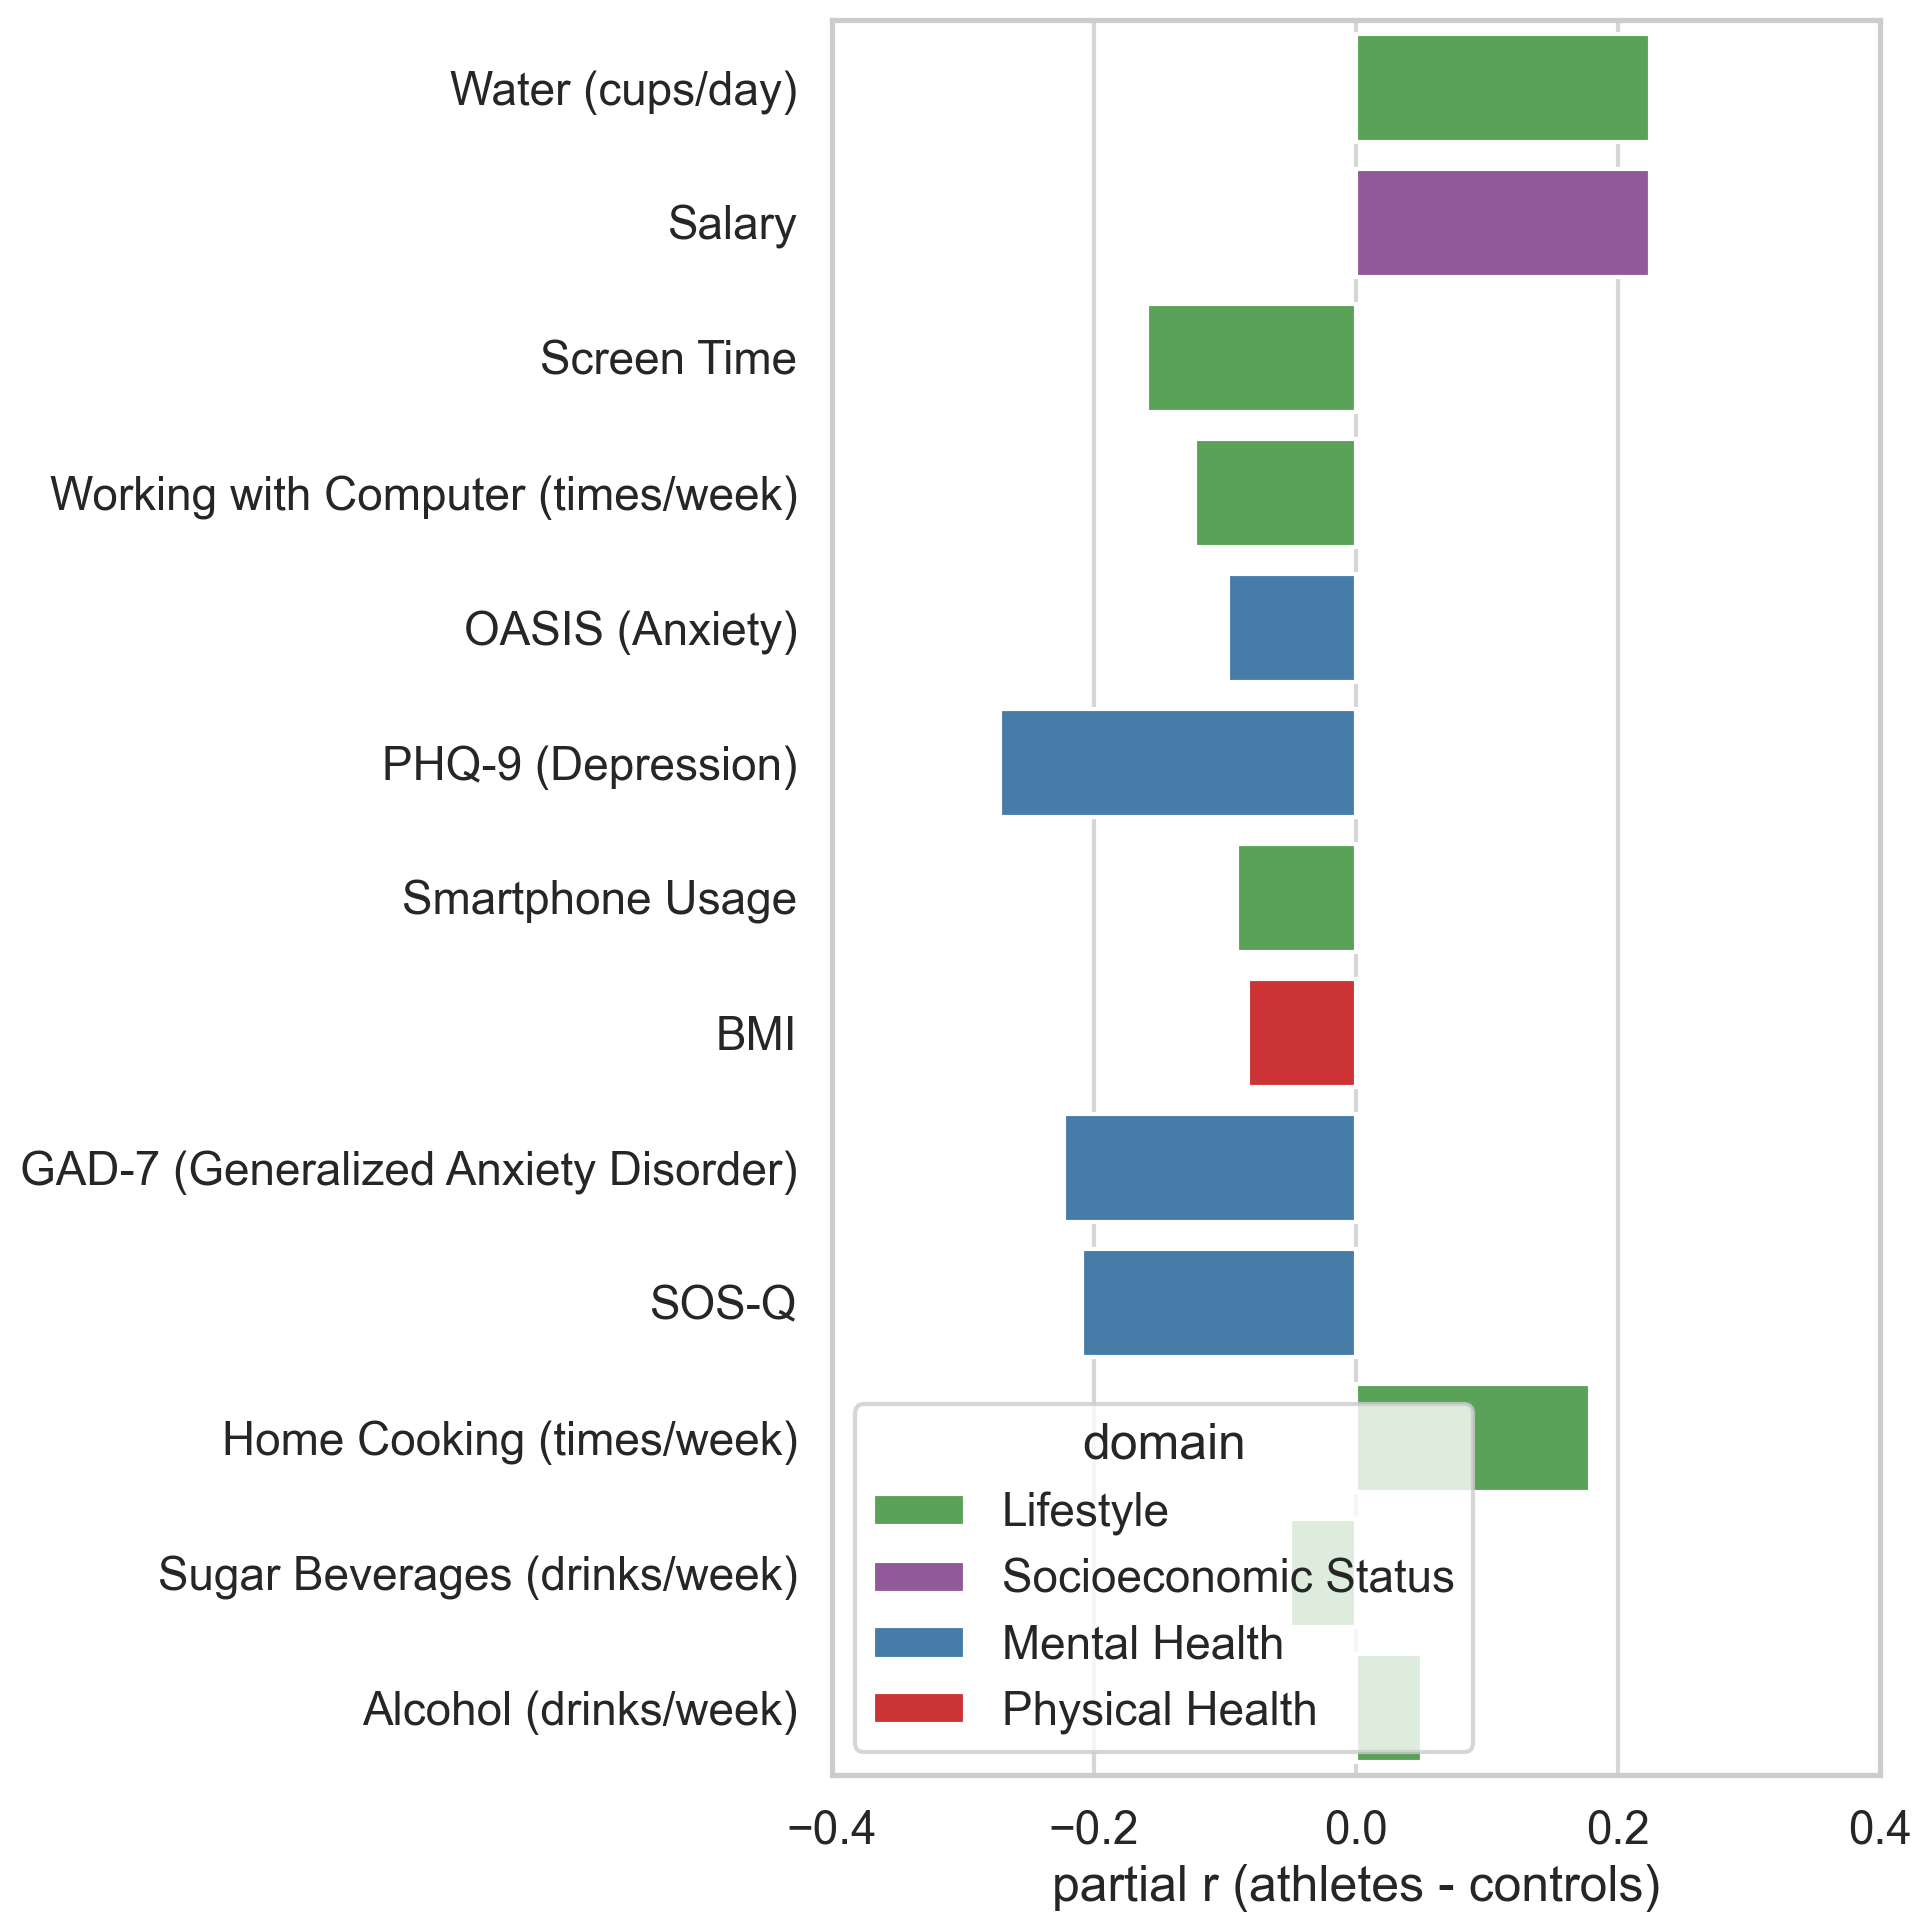

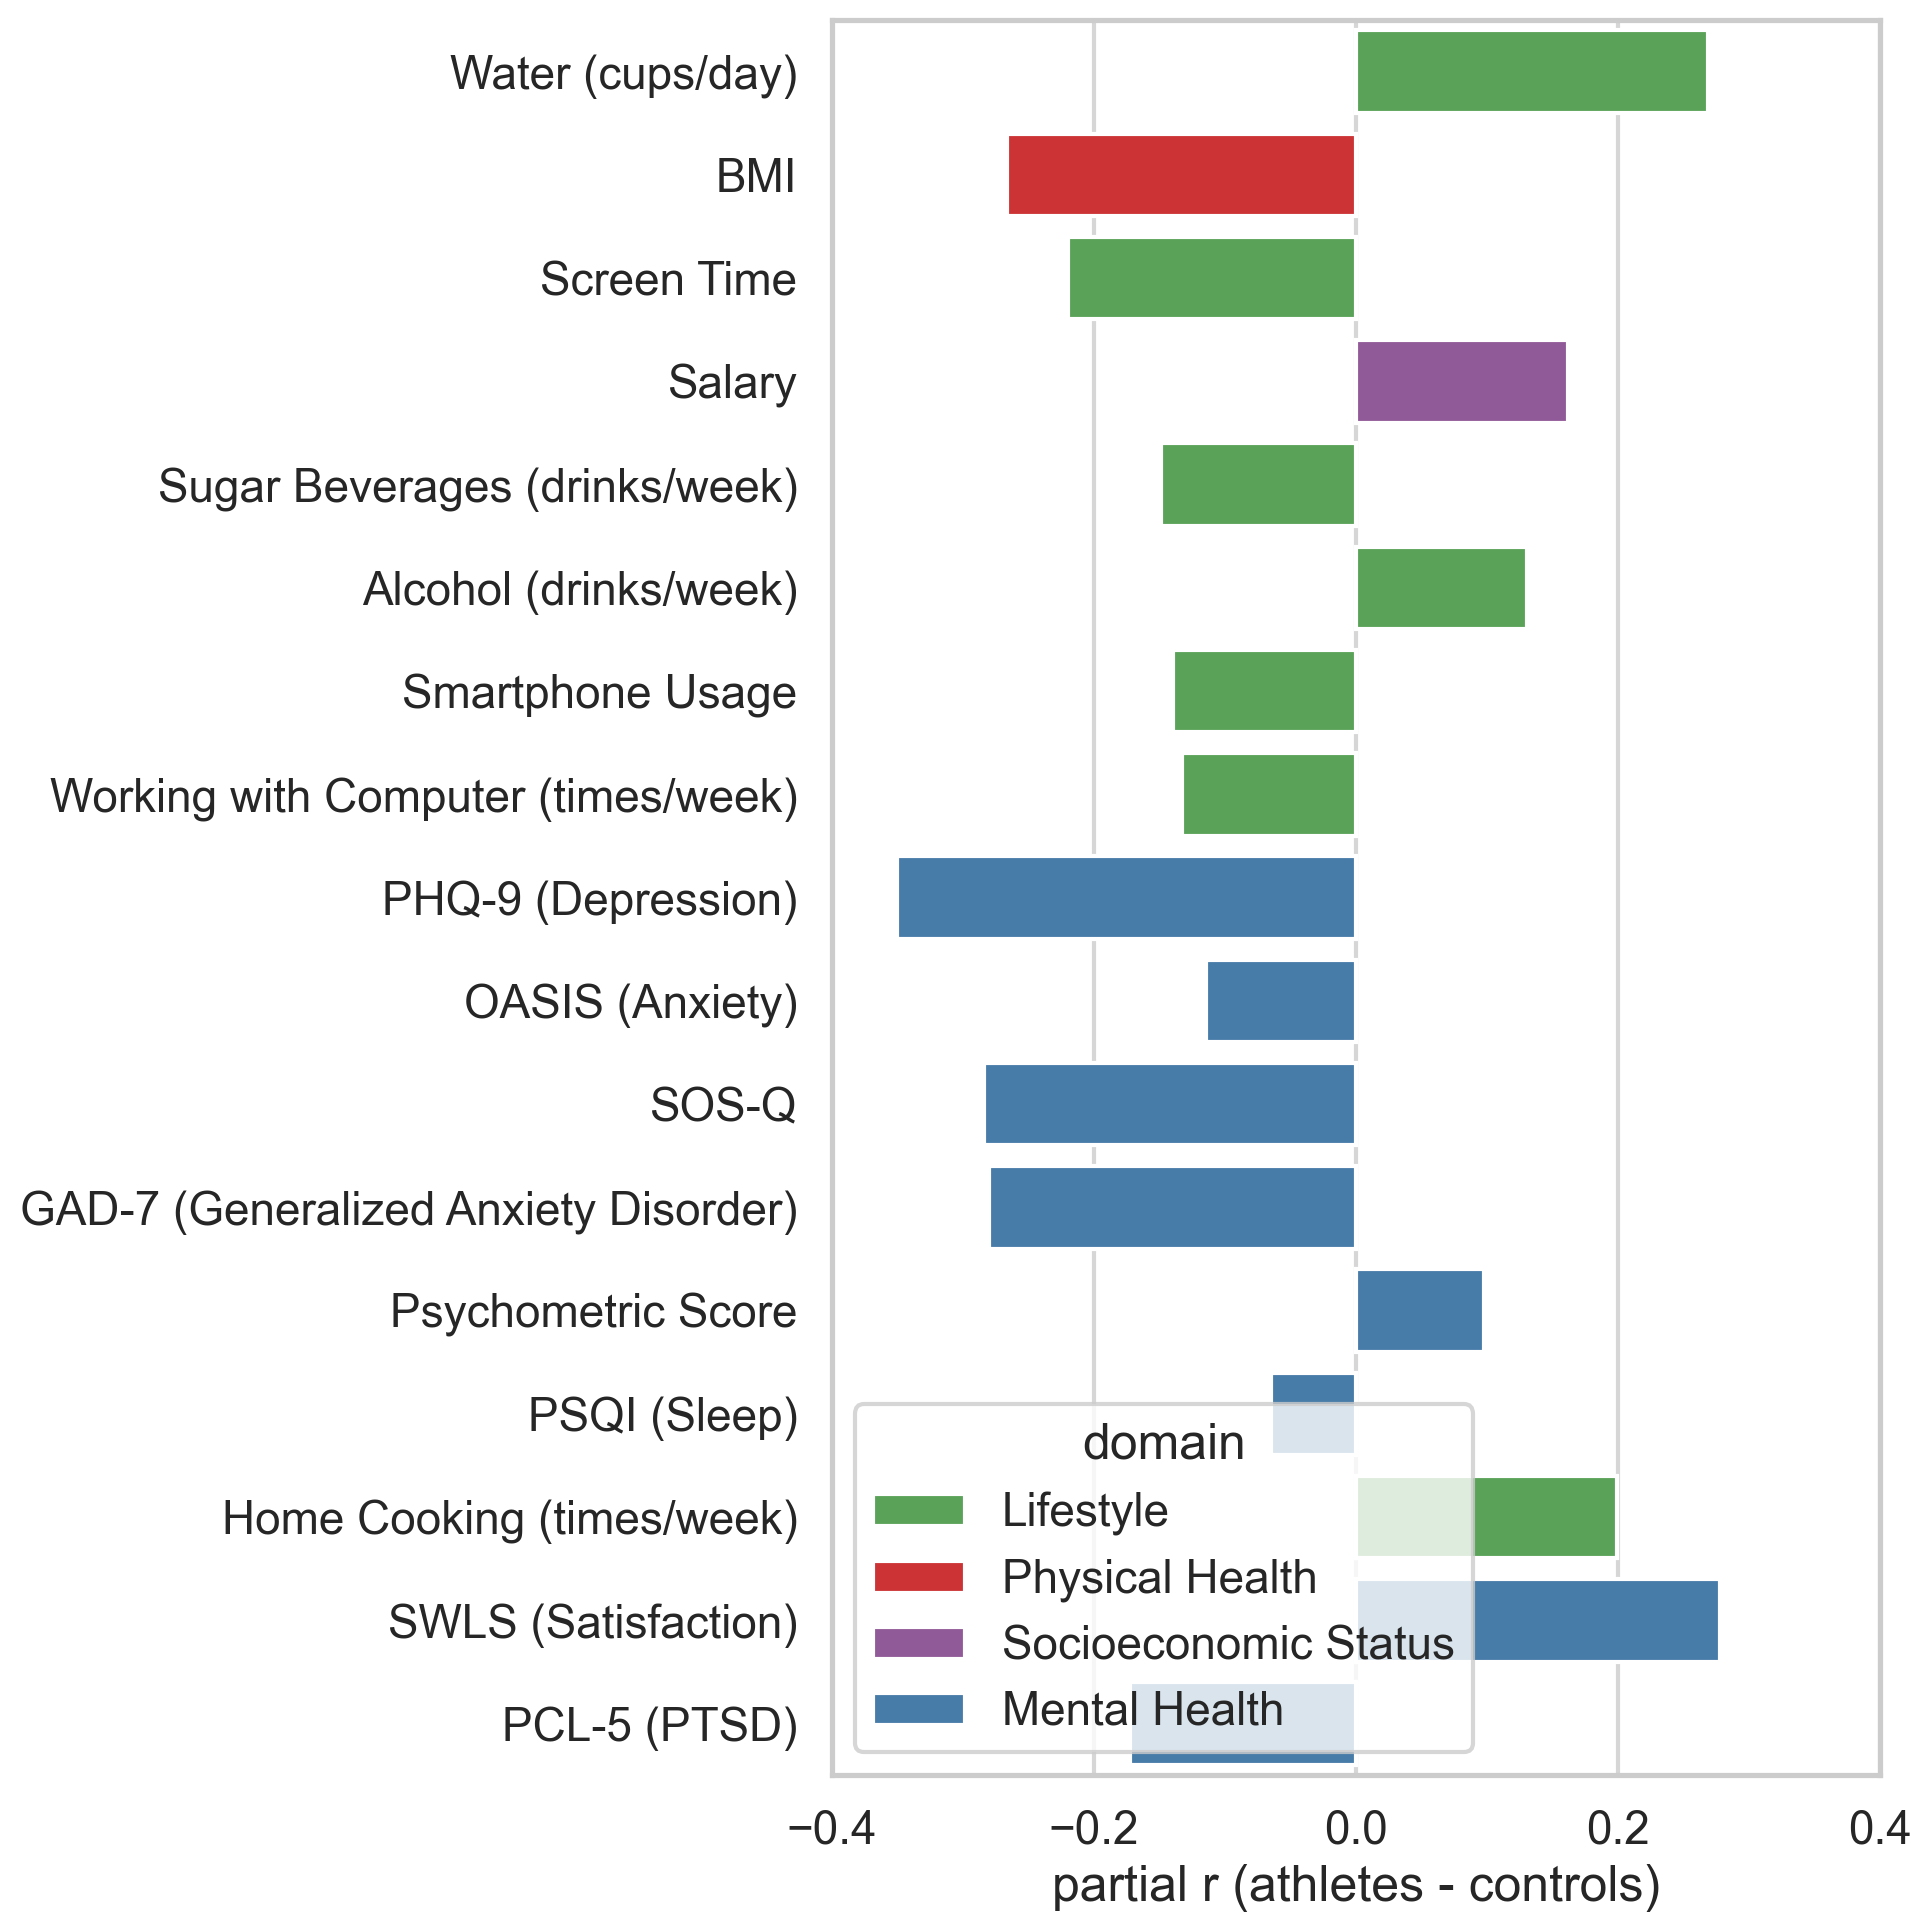

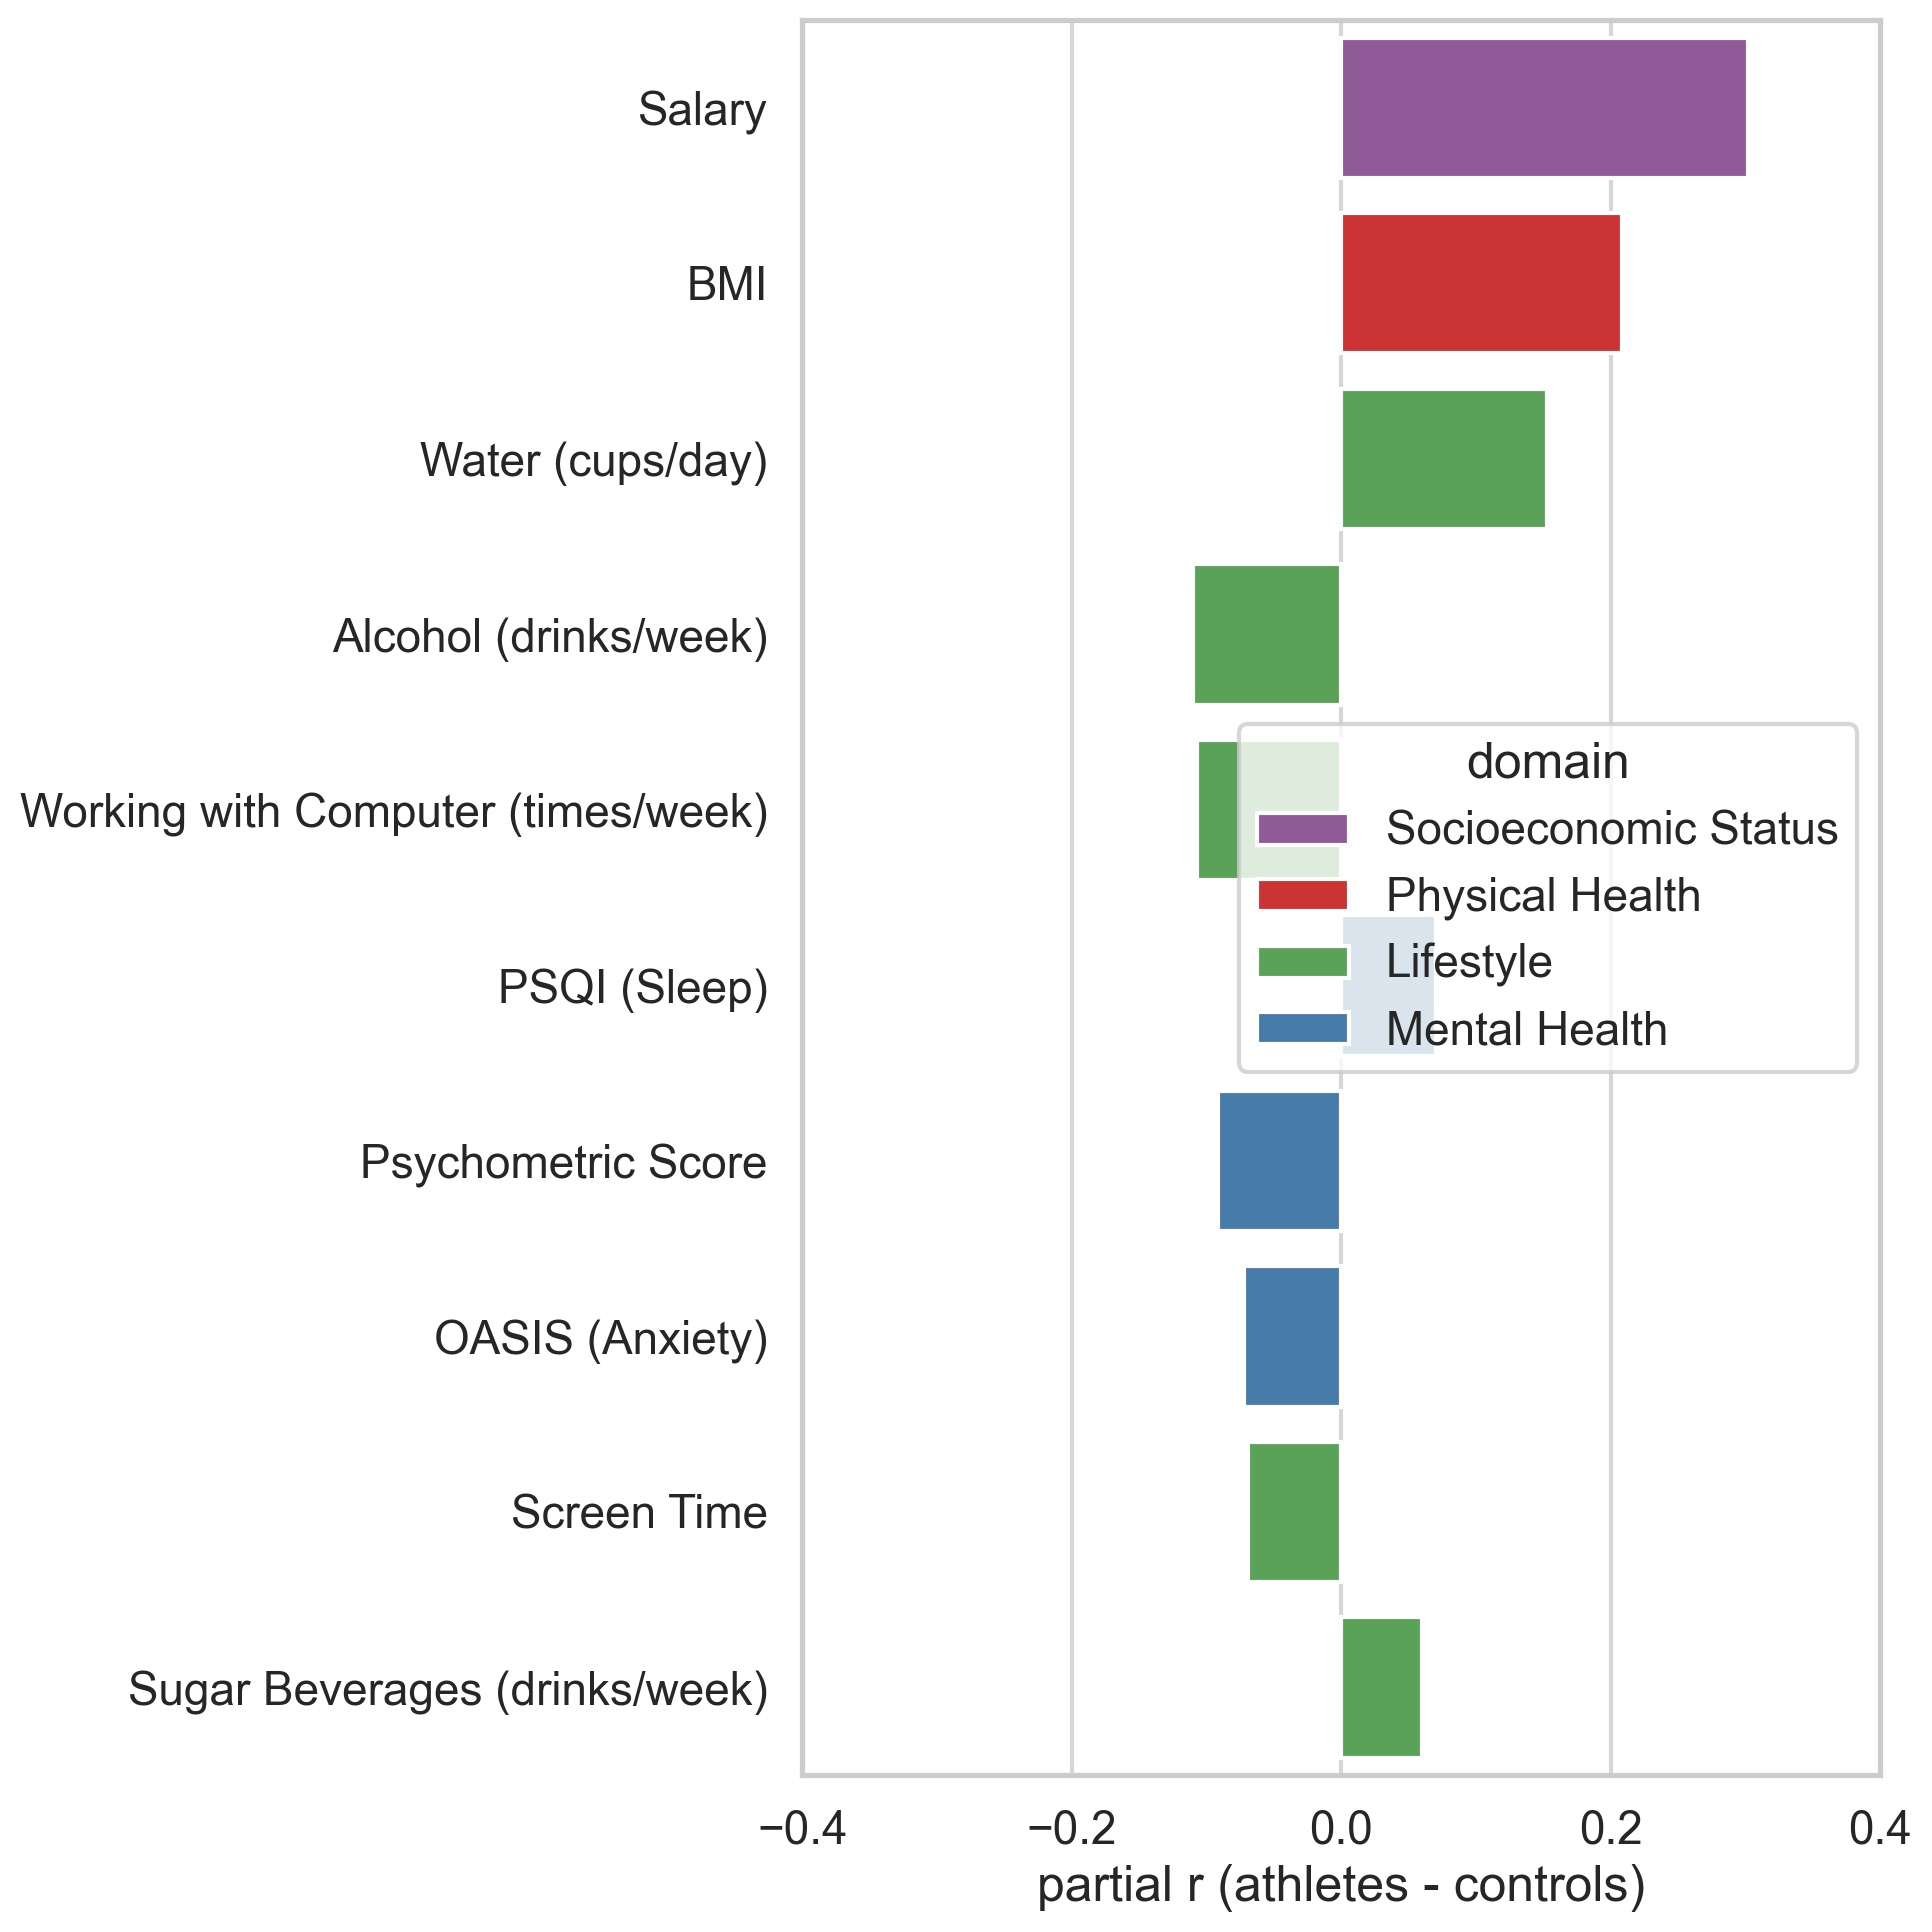

In [14]:
from athletes_brain.fig1.config import savefig_nice
import matplotlib as mpl

cmap = "Set1"

cmap = mpl.colormaps.get(cmap, 10)

domain_colors = {
    "Physical Health": cmap(0),
    "Mental Health": cmap(1),
    "Lifestyle": cmap(2),
    "Socioeconomic Status": cmap(3),
}


for group in ["all", "climbing", "bjj"]:
    vis = results[group].sort_values("p_value")
    # results
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.barplot(
        x="r_partial",
        y="vis_col",
        data=vis[vis["p_value"] < 0.05],
        ax=ax,
        hue="domain",
        palette=domain_colors,
    )
    # ax.set_title("Behavioral differences between athletes and controls")
    ax.set_xlabel("partial r (athletes - controls)")
    ax.set_ylabel("")
    ax.set_xlim(-0.4, 0.4)

    savefig_nice(fig, output_dir / f"{group}.png", dpi=400)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    permutation_test_score,
    GridSearchCV,
)
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding
import joblib
from xgboost import XGBClassifier
from sklearn.utils import class_weight

valid_columns = (
    df_cov[behav_columns]
    .columns[df_cov[behav_columns].isna().sum() / df_cov[behav_columns].shape[0] < 1]
    .tolist()
)

weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.array([False, True]), y=df_cov["target"] == "True"
)
class_weights = {False: weights[0], True: weights[1]}

# valid_columns = ['BMI',
#  'salary',
#  'psychometric_score',
#  'hli',
#  'psqi',
#  'oasis',
#  'screen_time',
#  'smartphone_usage',
#  'working_with_computer_times_per_week',
#  'water',
#  'alcohol',
#  'sugar_beverages']

logreg = LogisticRegression(max_iter=100, class_weight="balanced", random_state=42)
# logreg.classes_ = np.array([-1, 1])
# logreg = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1)
# logreg = HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight="balanced")
logreg = XGBClassifier(eval_metric="logloss", random_state=42)
grid = {
    # "classifier__C": [0.1, 1.0, 10.0],
    # "classifier__penalty": ["l2", None],
    # "classifier__max_depth": [3, 5, 10, None],
    # "classifier__learning_rate": [0.01, 0.1, 1.0],
    # "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__learning_rate": [0.01, 0.1, 1.0],
    "classifier__scale_pos_weight": [df_cov["target"].value_counts()[0] / df_cov["target"].value_counts()[1], 1],
    # "classifier__n_estimators": [100, 200, 300
}

group = "climbing"
target_file = output_dir / f"{group}_estimator.pkl"

FORCE = True

/tmp/ipykernel_1667292/2860302968.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "classifier__scale_pos_weight": [df_cov["target"].value_counts()[0] / df_cov["target"].value_counts()[1], 1],
/tmp/ipykernel_1667292/2860302968.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "classifier__scale_pos_weight": [df_cov["target"].value_counts()[0] / df_cov["target"].value_counts()[1], 1],


In [41]:
grid

{'classifier__max_depth': [3, 5, 10, None],
 'classifier__learning_rate': [0.01, 0.1, 1.0],
 'classifier__scale_pos_weight': [np.float64(13.015748031496063), 1]}

In [42]:
pred_df = df_cov.copy()
if group != "all":
    pred_df = pred_df.drop(
        pred_df[(pred_df["target"] == "True") & (pred_df["group"].str.lower() != group)].index
    )

X = pred_df[valid_columns]
y = pred_df["target"] == "True"

pipeline = Pipeline(
    [
        # ("imputer", SimpleImputer(strategy="mean")),
        # ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=3, random_state=42)),
        ("classifier", logreg),
    ]
)


if target_file.exists() and not FORCE:

    best_pipeline = joblib.load(target_file)
else:

    grid_search = GridSearchCV(pipeline, grid, cv=5, scoring="average_precision", n_jobs=-1, error_score='raise')

    grid_search.fit(X, y)

    best_pipeline = grid_search.best_estimator_

    # cross_val_score(pipeline, X, y, cv=5, scoring="average_precision")
    perm = permutation_test_score(
        best_pipeline,
        X,
        y,
        cv=5,
        n_permutations=1000,
        random_state=42,
        scoring="average_precision",
        n_jobs=-1,
    )
    print(f"Permutation test p-value: {perm[2]}")
    print(f"Best parameters: {grid_search.best_params_}")

    joblib.dump(best_pipeline, target_file)

Permutation test p-value: 0.000999000999000999
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__scale_pos_weight': np.float64(13.015748031496063)}


In [43]:
import shap

pipeline_without_estimator = best_pipeline[:-1] 

# X_scaled = pipeline_without_estimator.transform(X)
X_scaled = X.copy()

estimator = best_pipeline.named_steps["classifier"]

explainer = shap.TreeExplainer(estimator, X_scaled, model_output="probability")
shap_values = explainer(X_scaled, check_additivity=False)

<Axes: xlabel='value', ylabel='feature'>

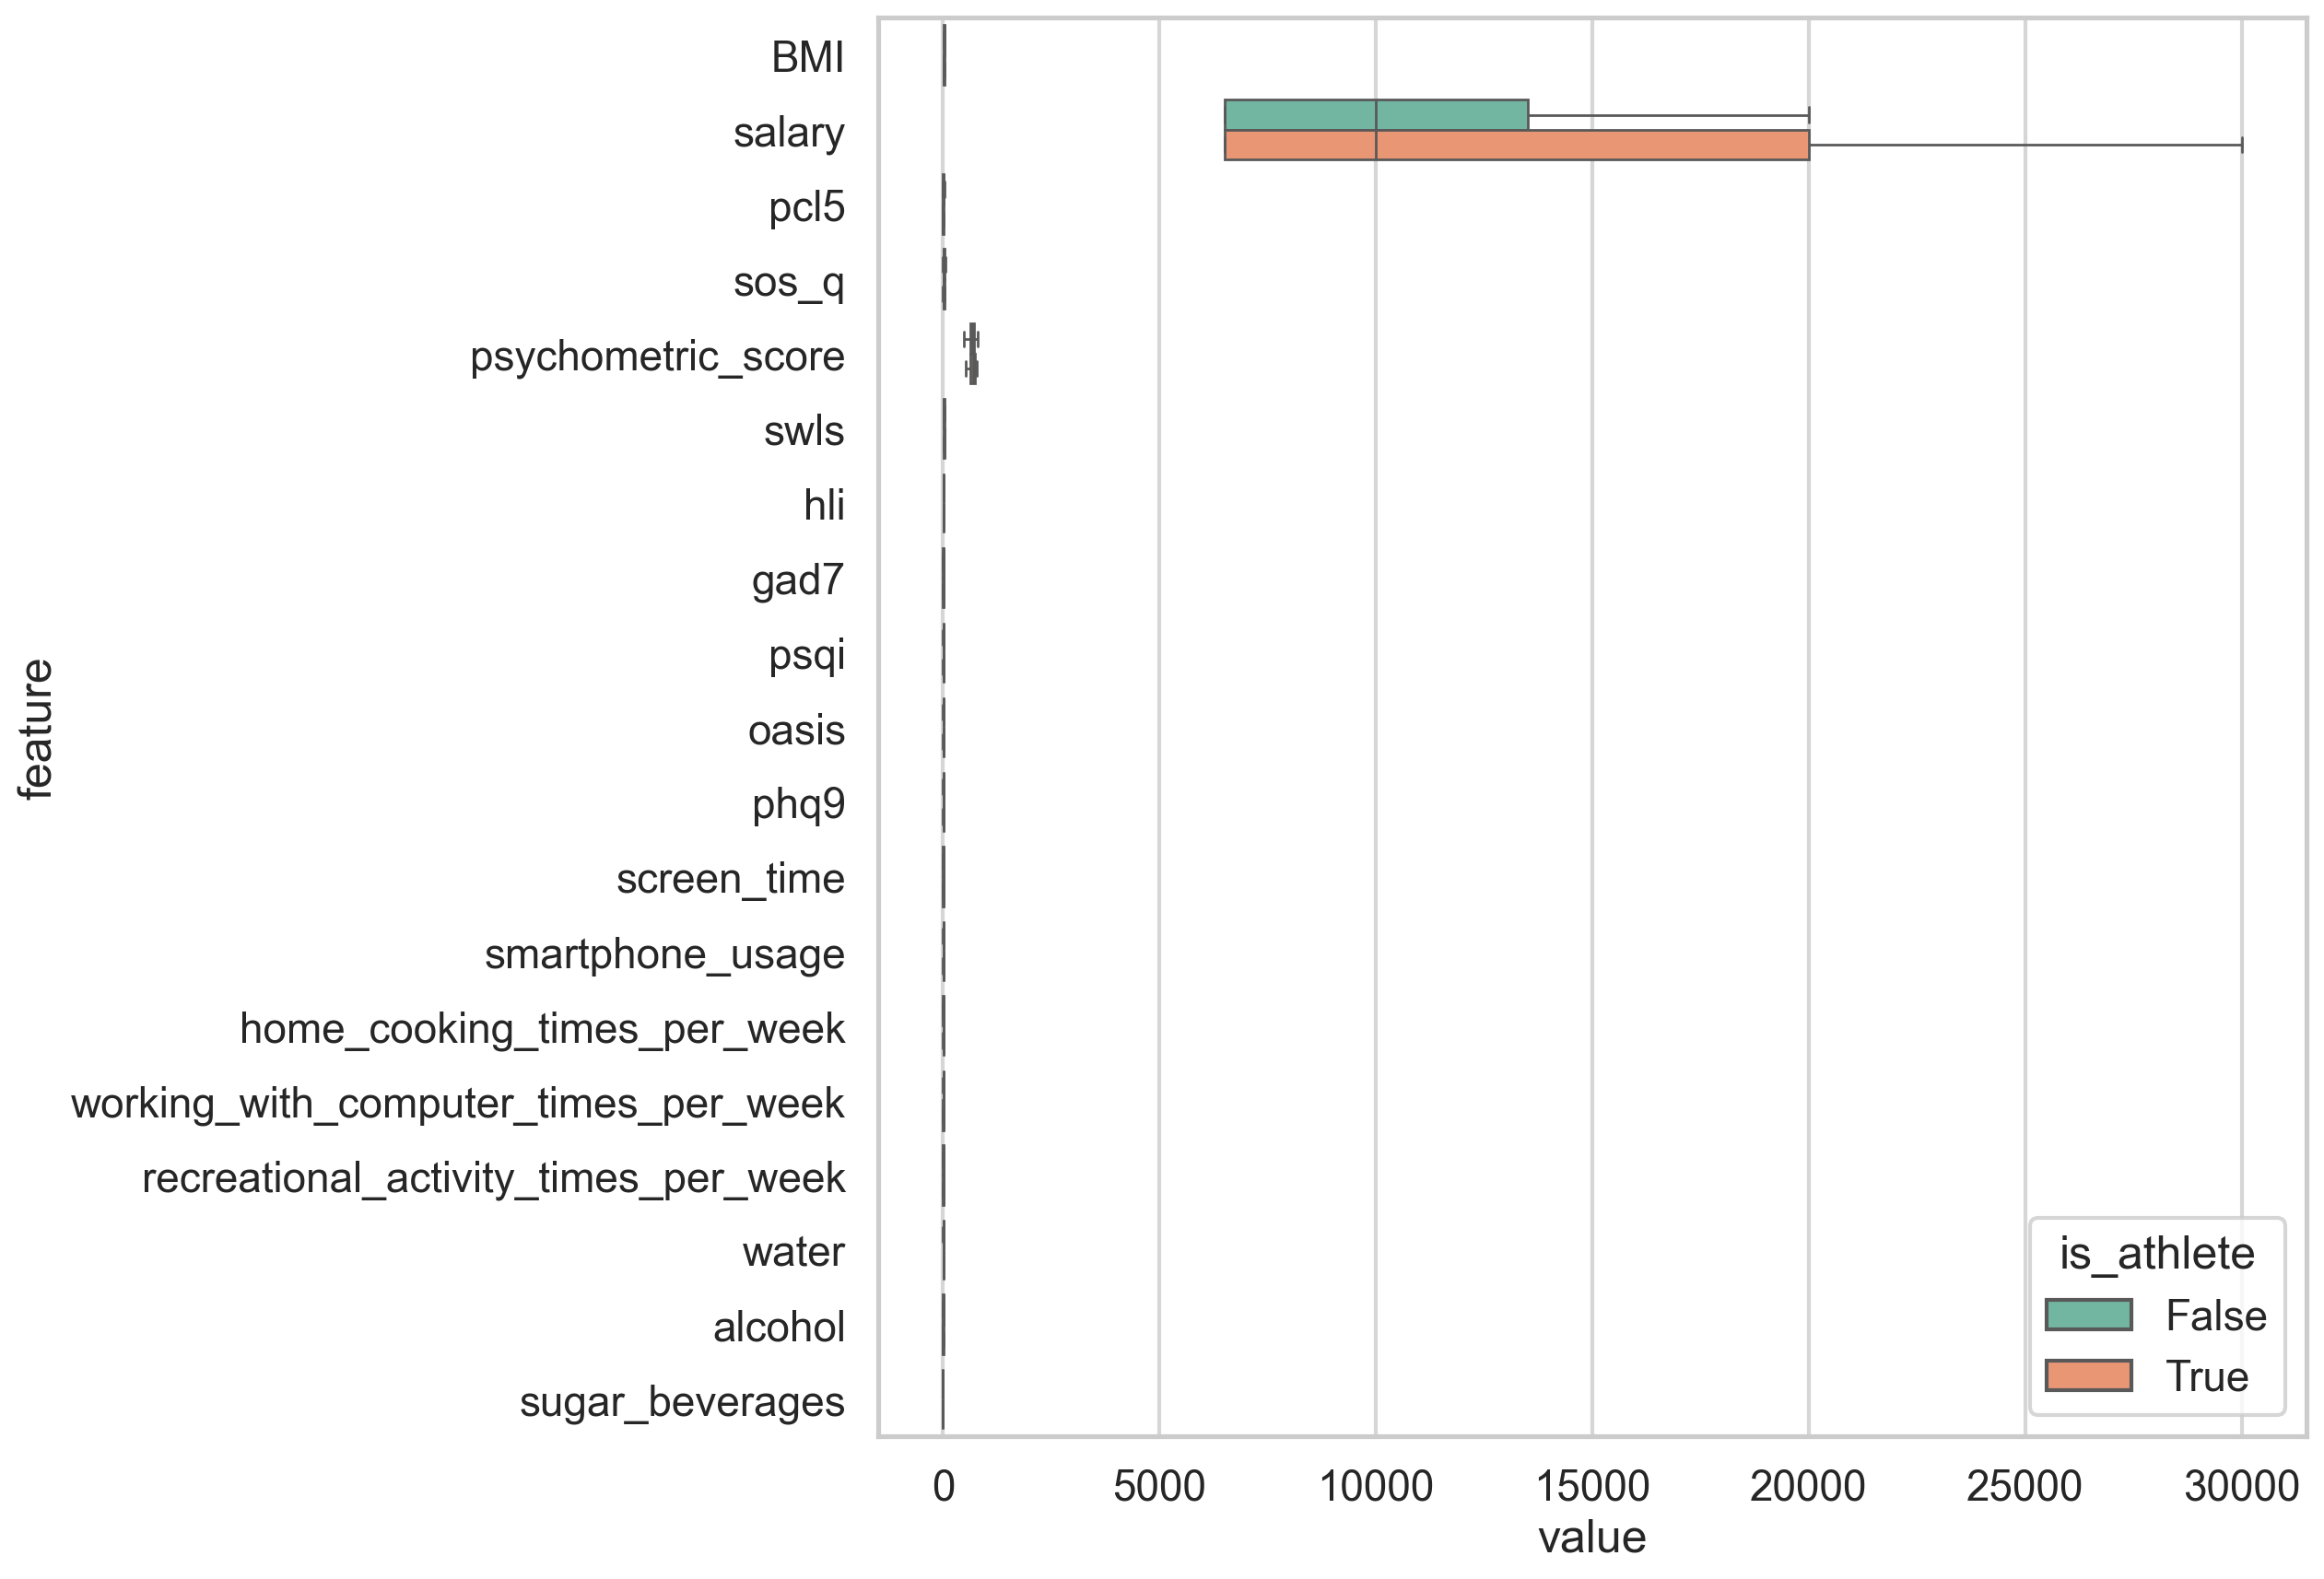

In [44]:
df_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
df_scaled["is_athlete"] = y
df_scaled_long = df_scaled.melt(id_vars=["is_athlete"], var_name="feature", value_name="value")


fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="value", y="feature", hue="is_athlete", data=df_scaled_long, showfliers=False, ax = ax)


In [45]:
# 3) Extract SHAP array and pick the athlete class (handle binary vs multiclass)
vals = shap_values.values
if vals.ndim == 3:
    # multiclass: shape (n_samples, n_classes, n_features)
    # find index of the athlete class explicitly
    classes = getattr(estimator, "classes_", None)
    # if your labels are 0/1 with 1 = athlete:
    athlete_idx = int(np.where(classes == 1)[0][0]) if classes is not None else 1
    vals_c = vals[:, :, athlete_idx]   # SHAP for the athlete class
else:
    # binary: shape (n_samples, n_features), already for the positive class
    vals_c = vals

# 4) Compute importance (mean|SHAP|) and direction (mean SHAP sign)
mean_abs = np.mean(np.abs(vals_c), axis=0)
mean_signed = np.mean(vals_c, axis=0)
std_signed = np.std(vals_c, axis=0)

In [46]:
feats_full = pd.DataFrame(vals_c, columns = [behav_vis.get(f, f) for f in X.columns])

directions = {
    feat: ("Toward athlete" if mean_signed[i] > 0 else "Toward non-athlete")
    for i, feat in enumerate(feats_full.columns)
}

shap_long = (
    feats_full.set_index(X.index)  # if index are sample IDs
    .reset_index()                               # if index are sample IDs
    .melt(
        id_vars='index',                         # column to keep (sample ID)
        var_name='feature',                      # name for feature column
        value_name='shap_value'                  # name for SHAP value column
    )
    .rename(columns={'index': 'sample'})
)
shap_long["Direction of difference"] = shap_long["feature"].map(directions)

# sort by mean absolute SHAP
shap_long["abs_shap"] = np.abs(shap_long["shap_value"])
mean_abs_shap = shap_long.groupby("feature")["abs_shap"].mean().reset_index()
mean_abs_shap = mean_abs_shap.sort_values("abs_shap", ascending=False)
shap_long["feature"] = pd.Categorical(
    shap_long["feature"],
    categories=mean_abs_shap["feature"],
    ordered=True
)
shap_long = shap_long.merge(y, left_on="sample", right_index=True)


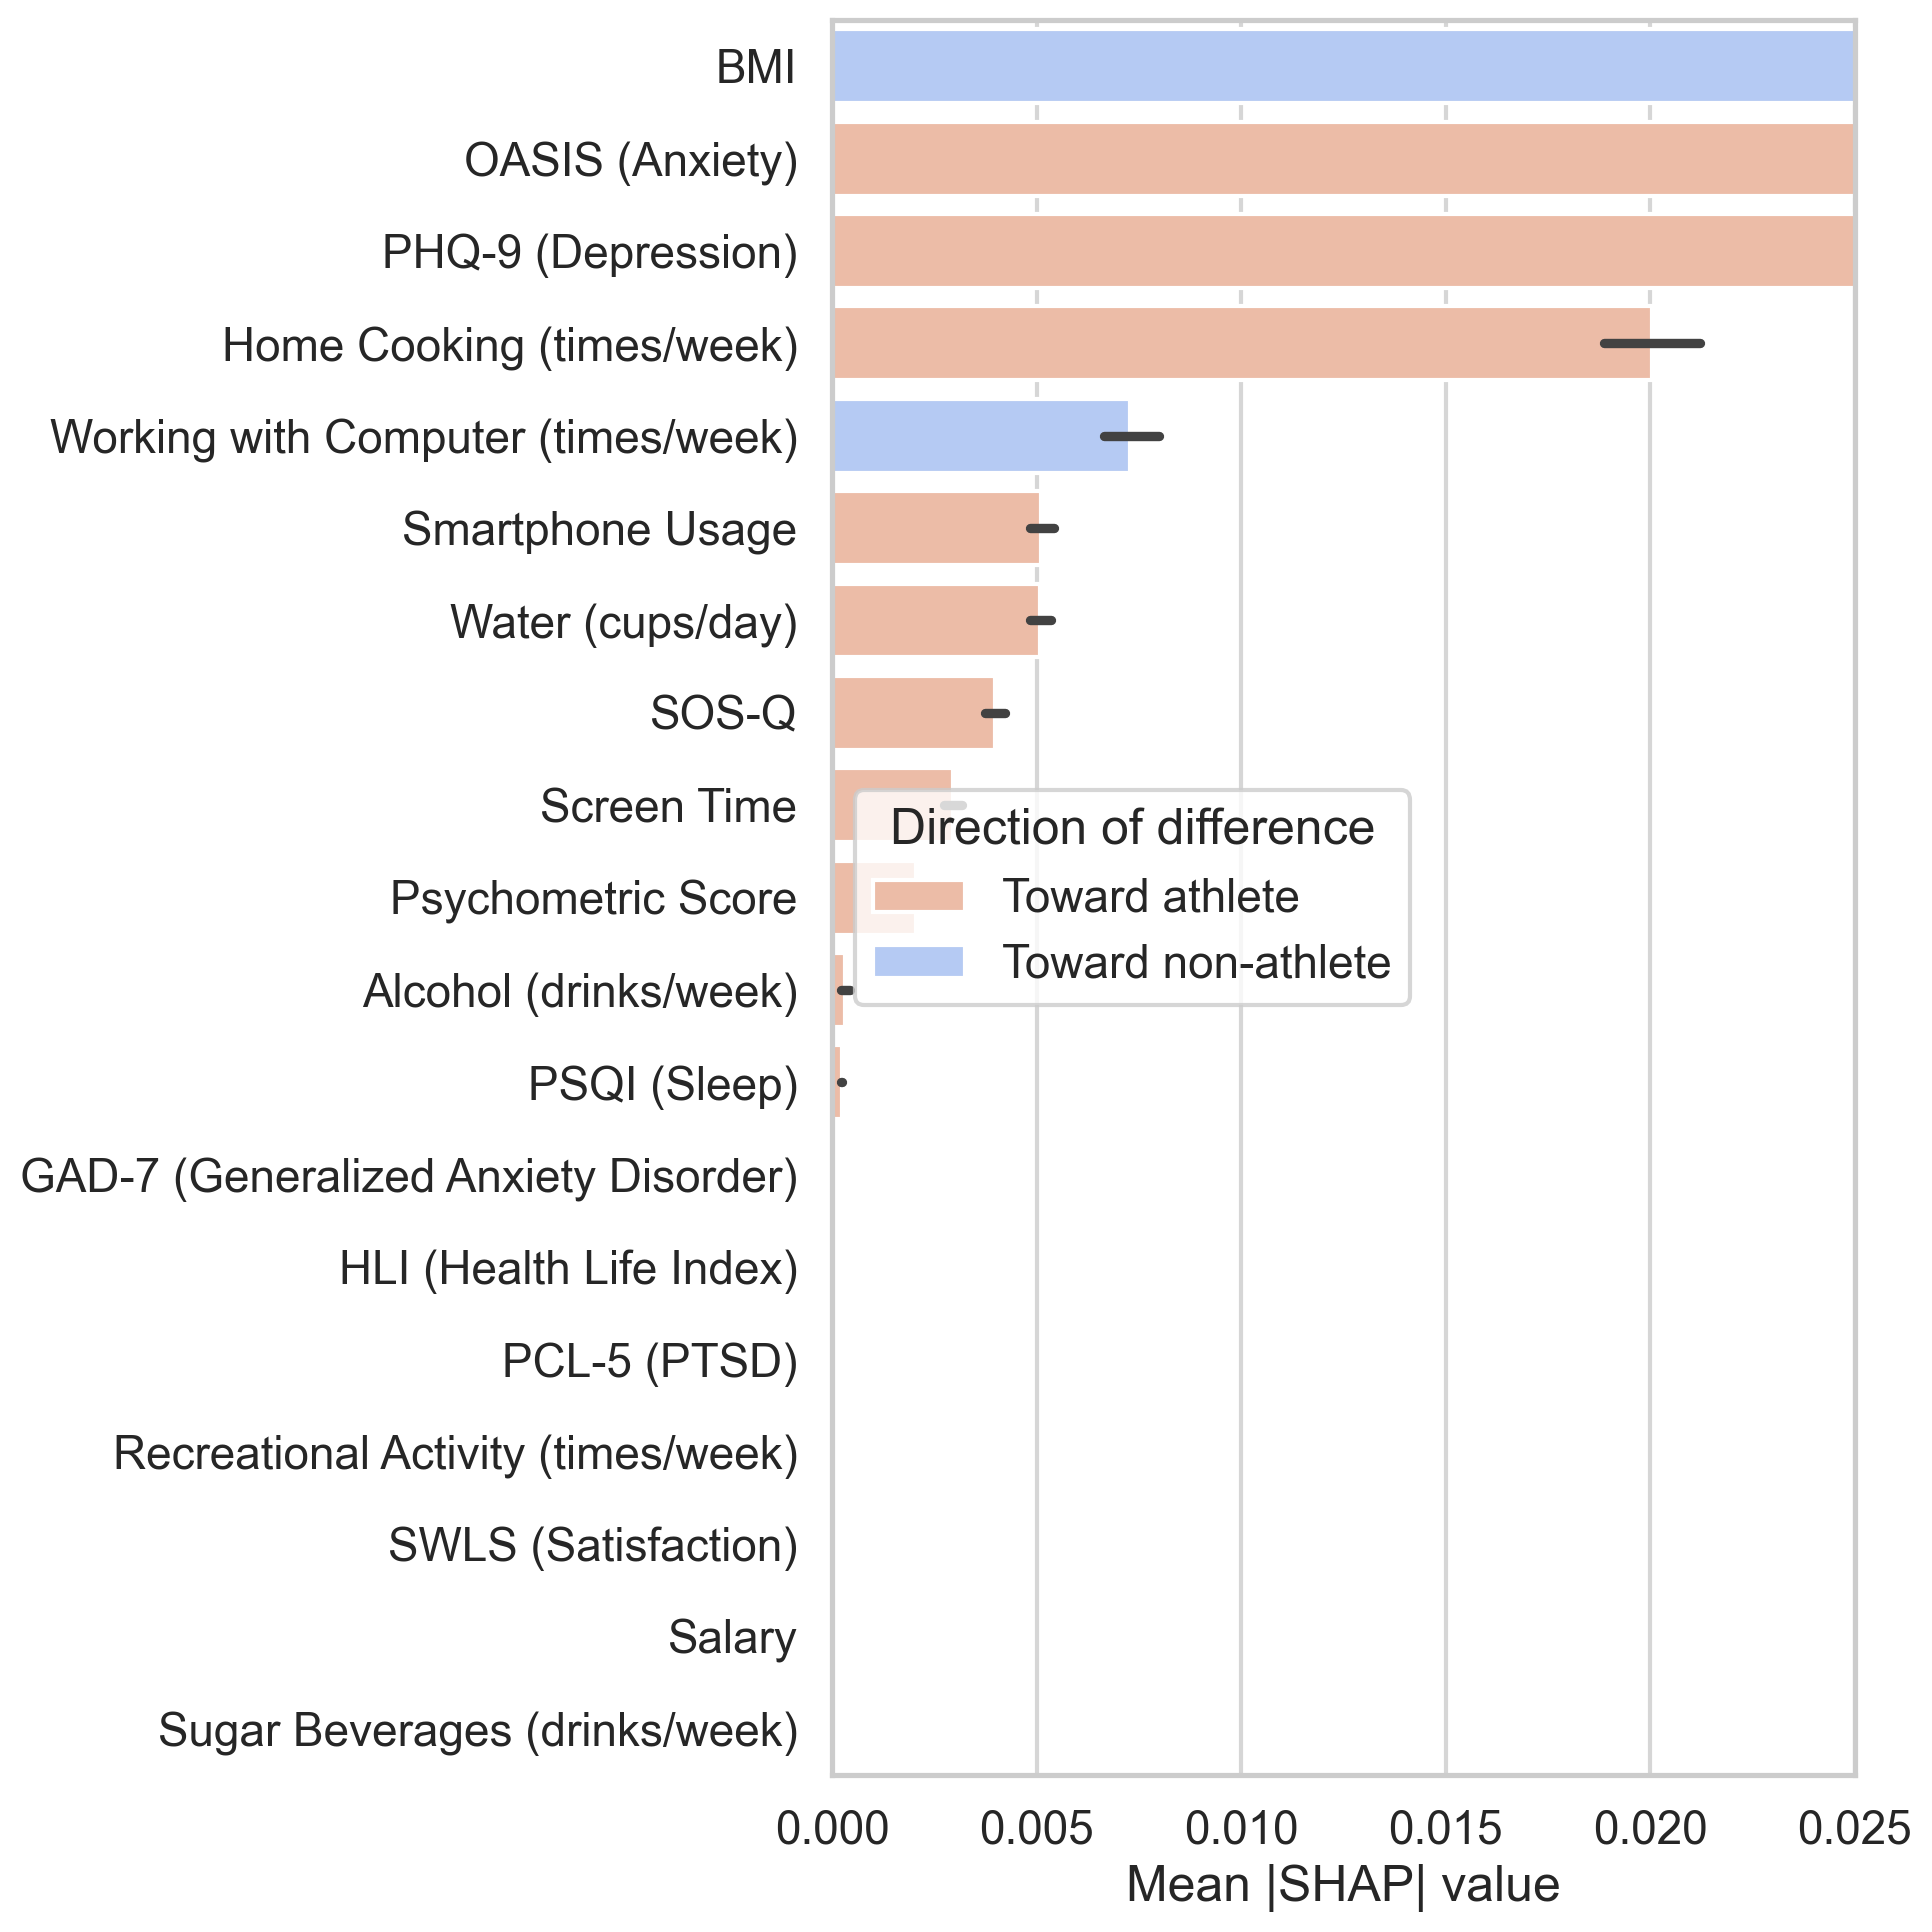

In [47]:

fig, ax = plt.subplots(figsize=(10, 10))

# barplot with error
sns.barplot(
    data=shap_long,
    x="abs_shap",
    y="feature",
    ax=ax,
    palette="coolwarm",
    hue_order=["Toward non-athlete","Toward athlete"],
    orient="h",
    # errorbar=None,
    hue="Direction of difference",
    # assign coolwarm colors based on direction (higher in athletes: first color, higher in non-athletes: second color
    # palette={"Higher in athletes": "coolwarm_r", "Higher in non-athletes": "coolwarm"},
)
# ax.errorbar(feats['shap'], feats['feature_name'], xerr=feats['shap_std'], fmt='none', c='black', capsize=5)
ax.set_xlabel("Mean |SHAP| value")
ax.set_ylabel("")
ax.legend(title="Direction of difference", loc = "center left")
# change order of label in the legend
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]  # new order
ax.legend([handles[i] for i in order], [labels[i] for i in order], title="Direction of difference", loc = "center left")

ax.set_xlim(0, 0.025)
savefig_nice(fig, output_dir / f"{group}_feature_importance.png", dpi=400)



In [48]:
feats = pd.DataFrame({
    "feature": X.columns,
    "feature_name": [behav_vis.get(f, f) for f in X.columns],
    "shap_mean_abs": mean_abs,
    "shap_mean": mean_signed,
    "shap_std": std_signed
})
feats["Direction of difference"] = np.where(
    feats["shap_mean"] > 0, "Higher in athletes", "Higher in non-athletes"
)

# Rank by importance (mean absolute SHAP)
feats = feats.sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)

In [49]:
# feats = pd.DataFrame(columns=["feature", "importance_mean", "importance_std"])
# # feats['importance_mean'] = importances.importances_mean
# # feats['importance_std'] = importances.importances_std
# feats["feature"] = X.columns
# feats["feature_name"] = [behav_vis.get(f, f) for f in feats["feature"]]
# # feats["shap"] = best_pipeline.steps[-1][-1].coef_.reshape(-1,1)
# feats["shap"] = shap_values[:, :, 1].values.mean(axis=0)
# feats["shap_std"] = shap_values[:, :, 1].values.std(axis=0)
# feats["Direction of difference"] = feats["shap"].apply(lambda x: "Higher in athletes" if x > 0 else "Lower in athletes")
# feats = feats.sort_values("shap", ascending=False)
# # feats = feats[feats['importance_mean'] > 0]

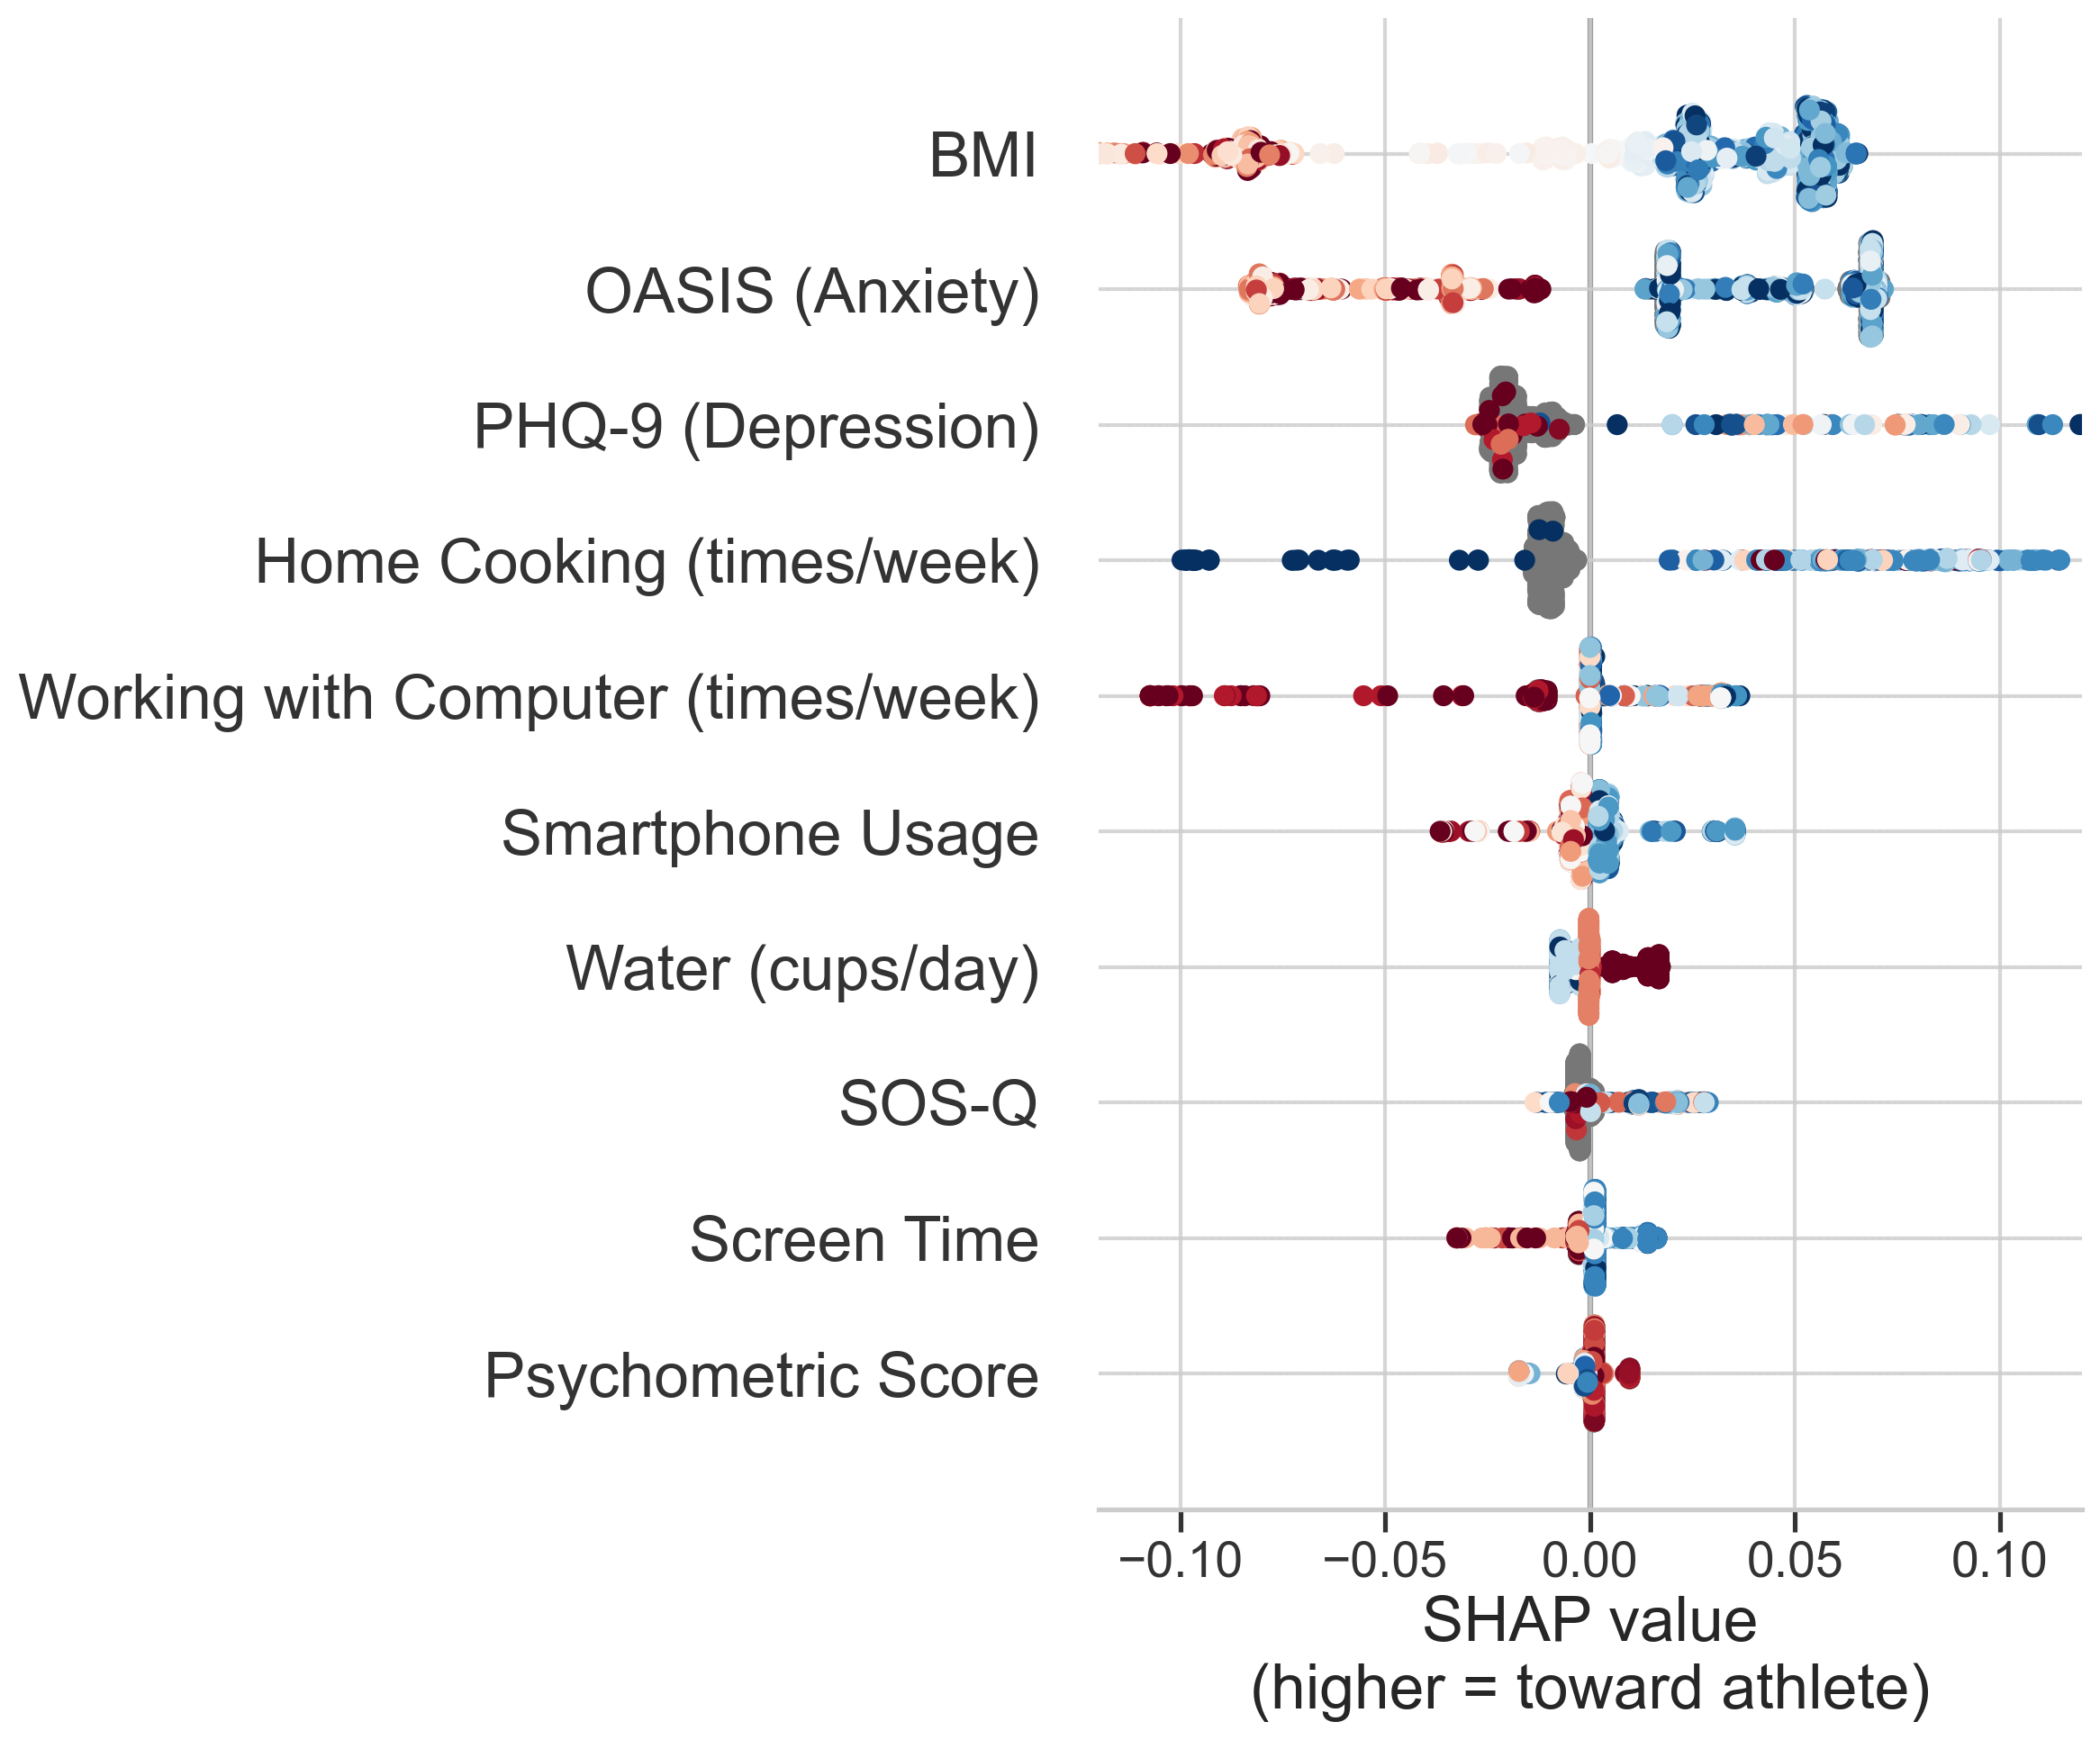

In [50]:
# create a colormap going from COL_weighted to COL_REF
from matplotlib.colors import LinearSegmentedColormap

col_weighted = config.COL_WEIGHTED
col_ref = config.COL_RAW


cmap = LinearSegmentedColormap.from_list("custom_cmap", [col_ref,col_weighted])

ax = shap.summary_plot(
    # shap_values[:, :, 1],
    shap_values,
    X,
    feature_names=shap_long["feature"].unique(),
    max_display=10,
    # cmap=cmap,
    cmap="RdBu_r",
    plot_size=(12, 10),
    # class_names=["Non-athlete", "Athlete"],
    # class_inds=[0, 1],
    sort=True,
    show=False,
    # hide colorbar
    color_bar=False,
)
# edit the axis
ax = plt.gca()
ax.set_xlabel("SHAP value\n(higher = toward athlete)", fontsize=25)
ax.set_ylabel("", fontsize=20)
# make points larger
for col in ax.collections:
    col.set_sizes([70])
    # set edgecolor to transparent
    col.set_edgecolor("none")
    
    
    # col.set_linewidth(0.5)
# change xlim
ax.set_xlim(-0.12, 0.12)
# make yticks larger
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=20)
fig = plt.gcf()

savefig_nice(fig, output_dir / f"{group}_shap_summary.png", dpi=400)


In [51]:
# fig, ax = plt.subplots(figsize=(10, 10))

# # barplot with error
# sns.barplot(
#     data=feats,
#     x="shap_mean_abs",
#     y="feature_name",
#     ax=ax,
#     palette="coolwarm",
#     orient="h",
#     errorbar=None,
#     hue="Direction of difference",
#     # add error bars (std)
# )
# # ax.errorbar(feats['shap'], feats['feature_name'], xerr=feats['shap_std'], fmt='none', c='black', capsize=5)
# ax.set_xlabel("Importance")
# ax.set_ylabel("")
# ax.legend(title="Direction of difference", loc = "center left")
# # make x-axis limits symmetric
# ax.set_xlim(-0.015, 0.015)
# savefig_nice(fig, output_dir / f"{group}_feature_importance.png", dpi=400)

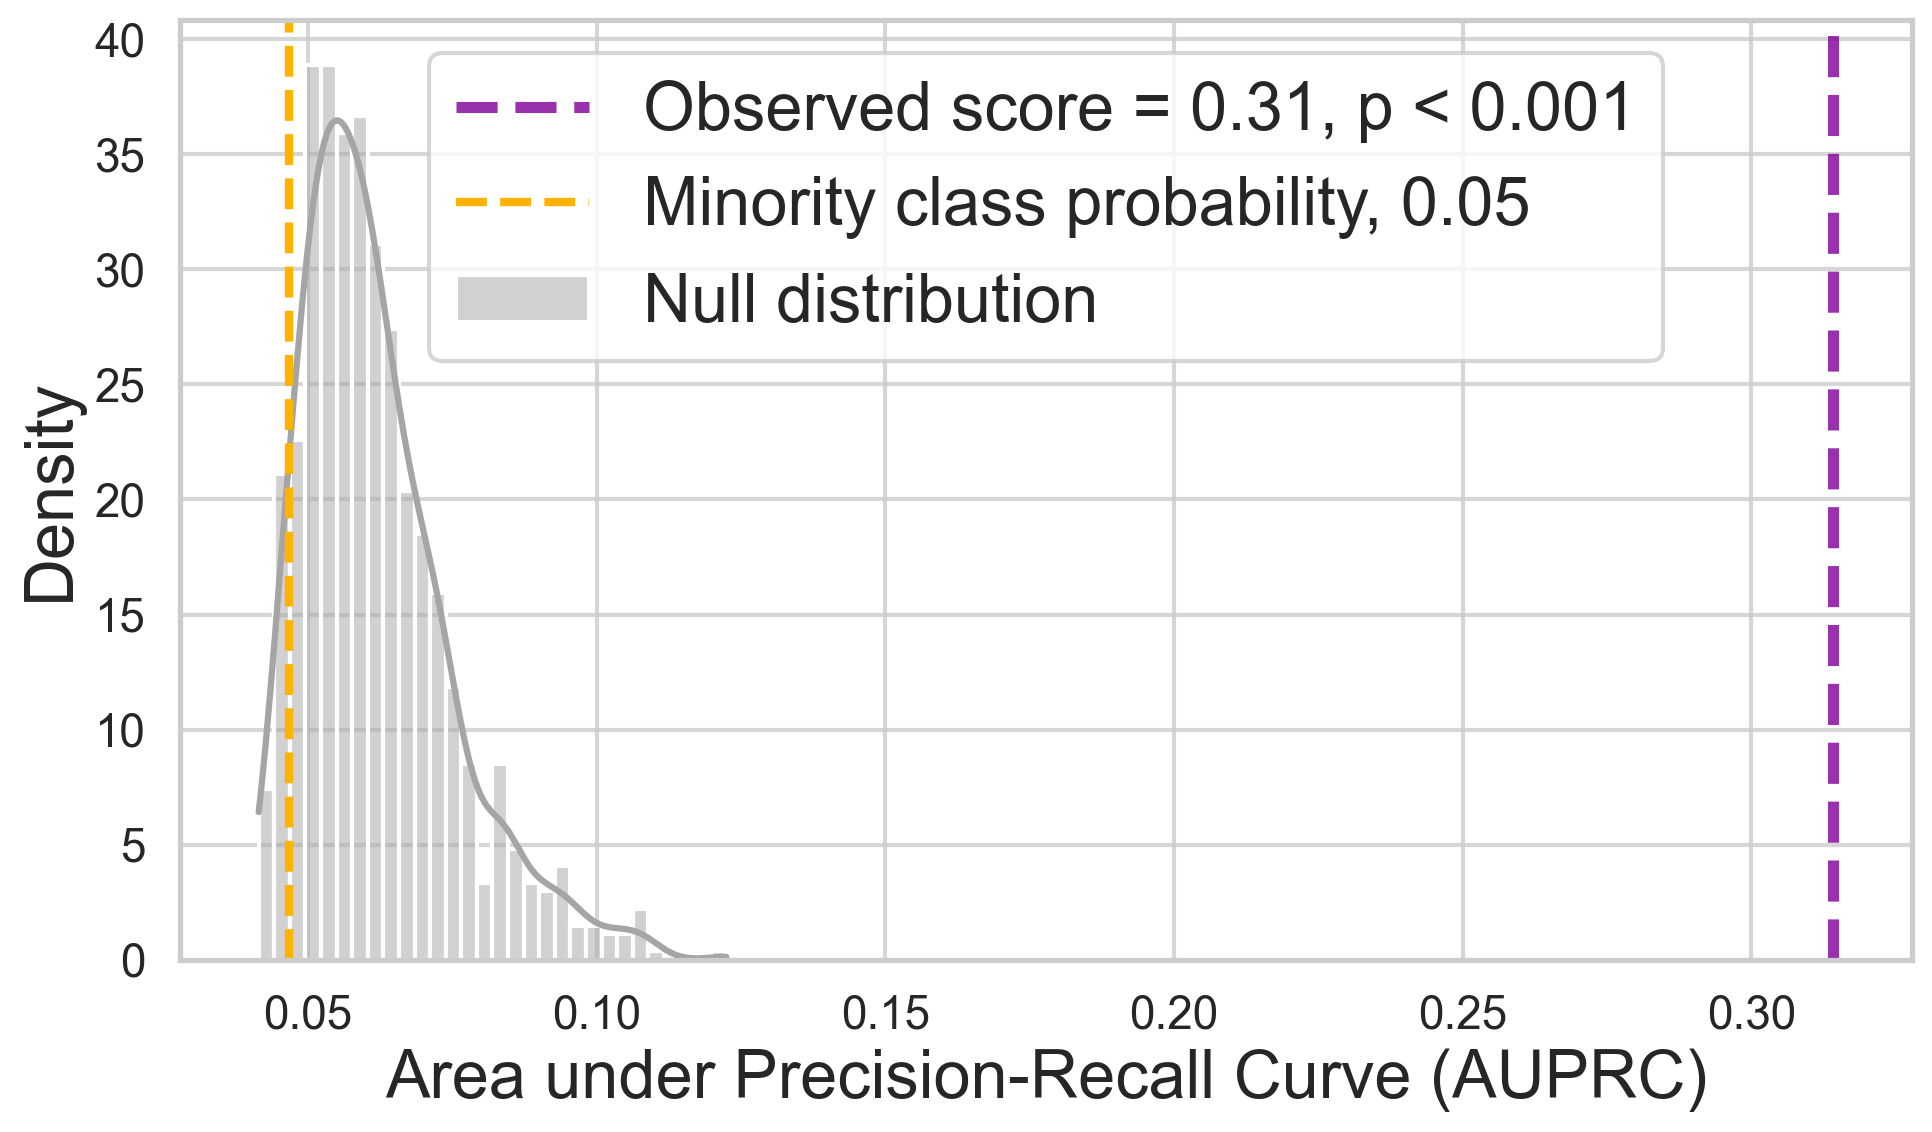

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    perm[1], bins=30, fill=True, color=config.COL_CENSUS, kde=True, stat="density", label="Null distribution", ax=ax
)
ax.axvline(perm[0], color=config.COL_WEIGHTED, linestyle="--", lw=4, label=f"Observed score = {perm[0]:.2f}, p < {perm[2]:.3f}")
# add a line for class probability of the minority class
minority_class_prob = np.min([y.mean(), 1 - y.mean()])
ax.axvline(minority_class_prob, color=config.COL_RAW, linestyle="--", lw=3, label=f"Minority class probability, {minority_class_prob:.2f}")
ax.legend(fontsize=24)
ax.set_xlabel("Area under Precision-Recall Curve (AUPRC)", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
savefig_nice(fig, output_dir / f"{group}_permutation.png", dpi=400)

In [ ]:
output_dir

PosixPath('/media/storage/phd/athletes_brain/figures/behavioral')